## 1.Data ETL

### 1.1 Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
from scipy import stats
import matplotlib
import csv
import re

In [ ]:
from ipywidgets import IntProgress
import pandas as pd
from IPython.display import display
from zipfile import ZipFile


all_files = ZipFile('/content/drive/MyDrive/HTWebLog_p1.zip', 'r')
files = all_files.namelist()

data = []
# Define the column names
ColumnNames=['date','time','s-sitename','s-ip','cs-method','cs-uri-stem','cs-uri-query','s-port','cs-username',
             'c-ip','cs(User-Agent)','cs(Referer)','sc-status','sc-substatus','sc-win32-status']
# Create a progress bar to track progress (importing data can take several minutes)
ProgressBar = IntProgress(value=0,min=0,max=len(files),step=1,
                          description='Loading:',bar_style='',orientation='horizontal')
display(ProgressBar)
# Read each of the files using the pandas read csv function within a 'for loop'
# and set data to str for each column to ensure all data loads
for name in all_files.namelist():
    ProgressBar.value += 1
    load_file = pd.read_csv(all_files.open(name),
                            delim_whitespace=True,
                            na_values='-',
                            skiprows = 4,
                            usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                            header=None,
                            encoding='iso-8859-1',
                            names=ColumnNames,
                            error_bad_lines=False,
                            warn_bad_lines=False,
                            dtype={'date': str,'time': str,'s-sitename': str, 's-ip': str,'cs-method': str,'cs-uri-stem': str,
                                   'cs-uri-query': str,'s-port': str,'cs-username': str,'c-ip': str,'cs(User-Agent)': str,
                                   'cs(Referer)': str, 'sc-status': str,'sc-substatus': str,'sc-win32-status': str})
    
    # There are rows with "#" in files, drop rows starts with "#"
    load_file = load_file[~load_file['date'].str.startswith("#")]
    
    data.append(load_file)

# Concatenate all the pandas dataframes into a single dataframe
df_ht = pd.concat(data)


print ('Finished loading', ProgressBar.value, 'web log files.')


IntProgress(value=0, description='Loading:', max=120)

Finished loading 120 web log files.


In [ ]:
#insepct dataset each column
for col in df_ht.columns:
      print('\n\n--------------------------')
      print('The number of unique {}:'.format(col),df_ht[col].nunique() )
      print(col, ":")
      print(df_ht[col].value_counts(), "\n")



--------------------------
The number of unique date: 121
date :
2006-12-12    120190
2006-11-27    120019
2006-12-14    118609
2006-12-13    117075
2006-12-08    113063
               ...  
2007-02-18     30750
2007-01-01     30355
2006-12-31     29400
2007-02-17     26484
2007-03-01         1
Name: date, Length: 121, dtype: int64 



--------------------------
The number of unique time: 86372
time :
08:37:00    382
09:55:14    375
09:13:05    358
04:41:05    349
06:30:22    343
           ... 
20:32:46      1
23:19:32      1
22:38:01      1
23:40:44      1
21:14:12      1
Name: time, Length: 86372, dtype: int64 



--------------------------
The number of unique s-sitename: 1
s-sitename :
W3SVC1    8438928
Name: s-sitename, dtype: int64 



--------------------------
The number of unique s-ip: 1
s-ip :
127.0.0.1    8438928
Name: s-ip, dtype: int64 



--------------------------
The number of unique cs-method: 6
cs-method :
GET         8421984
POST           9509
HEAD           6723

In order to reduce the processing time, we will remove all missing values for data and only select 30% of total data for classification. 


    1. Remove all NAs, for the columns, if the column is with 15% NAs, I remove that column. Then, for the rows, if there are any NAs in that row, I remove that row as well.  
    2. Select 30 % of the total data in to a new dataframe weblog_df.

**Report**:
    The number of requests in weblog\_df.


In [ ]:
#Your code to remove missing values as required.
#missing counts by column
print(df_ht.isnull().sum(axis=0))


date                     0
time                     0
s-sitename               0
s-ip                     0
cs-method                0
cs-uri-stem              0
cs-uri-query       7886532
s-port                   0
cs-username        8438928
c-ip                     0
cs(User-Agent)        3527
cs(Referer)        1308994
sc-status                0
sc-substatus             0
sc-win32-status          0
dtype: int64


In [ ]:
#missing value percentage
missing_value = (df_ht.isnull().sum(axis=0)*100/len(df_ht))\
                    .reset_index().rename(
                      columns = {"index": "columns", 
                                 0: "% percent of missing value"})\
                          .sort_values(
                              by="% percent of missing value", 
                              ascending=False)

print(missing_value[missing_value['% percent of missing value'] != 0])

           columns  % percent of missing value
8      cs-username                  100.000000
6     cs-uri-query                   93.454192
11     cs(Referer)                   15.511378
10  cs(User-Agent)                    0.041794


In [ ]:
# remove columns have above 15% missing value
drop_columns = list(missing_value[missing_value['% percent of missing value'] > 15]['columns'])

print('After dropping columns above 15% missing values\n')
df_ht.drop(columns = drop_columns , axis =1, inplace = True)

print(df_ht.isnull().sum())
print(df_ht.shape)

After dropping columns above 15% missing values

date                  0
time                  0
s-sitename            0
s-ip                  0
cs-method             0
cs-uri-stem           0
s-port                0
c-ip                  0
cs(User-Agent)     3527
sc-status             0
sc-substatus          0
sc-win32-status       0
dtype: int64
(8438928, 12)


In [ ]:
#remove any records with missing values
df_ht.dropna( axis=0 , how = 'any',inplace = True)
print('After drop any records with mising value\n')
print(df_ht.isnull().sum())

After drop any records with mising value

date               0
time               0
s-sitename         0
s-ip               0
cs-method          0
cs-uri-stem        0
s-port             0
c-ip               0
cs(User-Agent)     0
sc-status          0
sc-substatus       0
sc-win32-status    0
dtype: int64


In [ ]:
df_ht.shape

(8435401, 12)

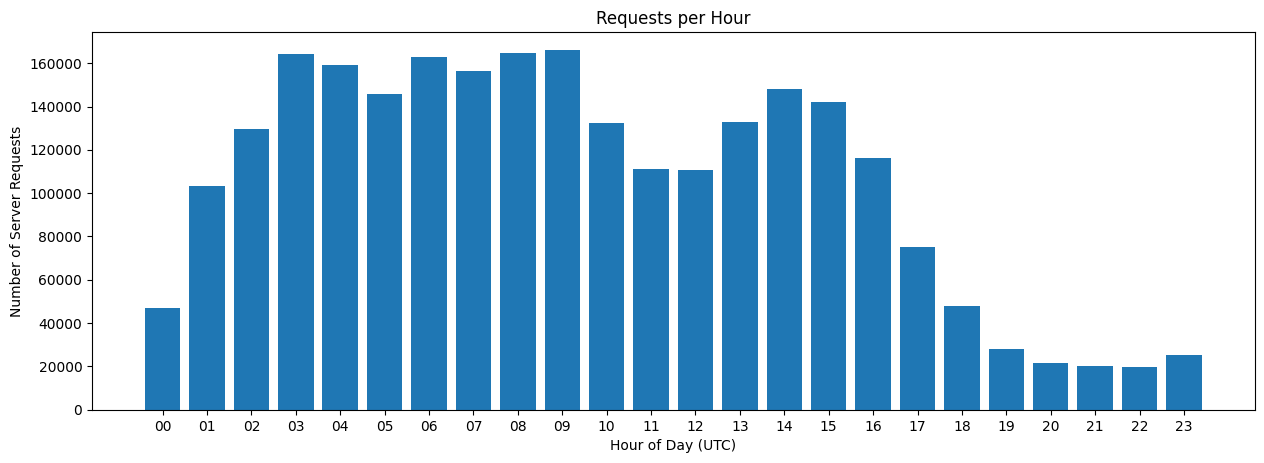

In [ ]:
# only 30% of total data are selected for classification
weblog_df = df_ht.sample(frac = 0.3, random_state=1)

# show the number of requests in weblog_df
# Create a bar chart of the number of server requests by hour of the day

# Create a new column in the pandas dataframe of the hour-of-the-day
weblog_df['TimeOfDay'] = weblog_df['time'].str[:2]

# Create an array of row counts for each of the hours-of-the-day
uniqueTimeOfDay, countTimeOfDay = np.unique(weblog_df['TimeOfDay'], return_counts=True)

# Plot data with a bar chart and export the chart to a png image file for use in a report
fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
x_pos = np.arange(len(countTimeOfDay))
ax.bar(x_pos, countTimeOfDay, align='center')
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('Number of Server Requests')
ax.set_title('Requests per Hour')
ax.set_xticks(x_pos)
ax.set_xticklabels(uniqueTimeOfDay)
fig.savefig('HitsPerHour.png', bbox_inches='tight')


##### The figure above displays that the highest numbers of requests in weblog_df are 03, 06, 08 and 09 (around 160,000) while the lowest are 20, 21 and 22 (around 20,000).

### 1.2 Feature Selection

**Code**: 
    Select *'cs_method'*,*'c_ip'*,*'cs_uri_stem'*,*'cs(User_Agent)'* as input features  and 'sc_status' as class label into a new dataframe ml_df for following Machine Learning Tasks. 

**Report**: <br>
    1. Data Description of ml_df,  
    2. Print top 5 rows of ml_df.



In [ ]:
# feature selection
ml_df = weblog_df[['cs-method','c-ip','cs-uri-stem','cs(User-Agent)','sc-status']]

# show the top 5 rows of ml_df
ml_df.head(5)

,cs-method,c-ip,cs-uri-stem,cs(User-Agent),sc-status
25357,GET,218.102.231.100,/Tulip/common/en-us/images/topmenu_zh-hk.gif,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200
89819,GET,218.190.226.30,/Tulip/common/en-us/images/top_logo.gif,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200
19333,GET,203.241.147.26,/Tulip/common/en-us/images/sectionbanner_about...,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,304
29761,GET,203.85.132.97,/Tulip/public/2899_2.jpg,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200
52909,GET,218.186.9.5,/Tulip/common/en-us/images/topmenu_zh-hk.gif,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200


In [ ]:
#Data Description of ml_df
ml_df.describe()

,cs-method,c-ip,cs-uri-stem,cs(User-Agent),sc-status
count,2530620,2530620,2530620,2530620,2530620
unique,6,69837,3616,4653,12
top,GET,59.188.33.66,/Tulip/common/common_style.aspx,Mozilla/4.0+(compatible;+MSIE+6.0;+Windows+NT+...,200
freq,2525568,27935,121304,594218,1821993


The figure above illustrates the count, unique, top and frequency of five attributes including cs-method, c-ip, cs-uri-stem, cs(User-Agent) and sc-status.

## 2.Unsupervised Learning
 using **sklearn**.


**Code**: 
    1. Perform unsupervised learning on ml_df with K Means, with a varying K from 2 to 10;
    2. Plot in the elbow plot. 

**Report**:
    1. Figure 'KMeans' in the elbow plot, with a varying K from 2 to 10.



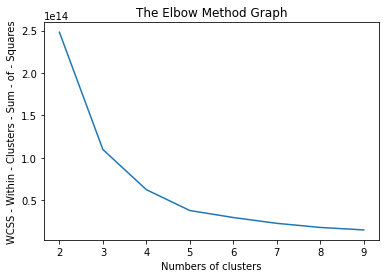

In [ ]:
from sklearn import preprocessing
from sklearn.cluster import KMeans 

le_df = ml_df.apply(preprocessing.LabelEncoder().fit_transform)

data_no_labels = le_df.drop('sc-status', axis = 1) #set the X data set

#Your code for Kmeans
wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data_no_labels)
    wcss.append(kmeans.inertia_)
#Your code for visualizing K means result as elbow plot.
plt.plot(range(2,10), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Numbers of clusters')
plt.ylabel('WCSS - Within - Clusters - Sum - of - Squares')
plt.show()



##### The figure above shows that the best k is 4 which also means the sum of squares within clusters is minimum (0.5).

## 3.Supervised Learning
using **PySpark**.


In [ ]:
!apt-get update
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.1.1
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# unzip it
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# install findspark 
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark 
findspark.init() 

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [ ]:
from pyspark.sql import SparkSession 
from pyspark.sql.types import *

spark = SparkSession.builder.appName('HotelTulip_Weblog').getOrCreate()

### 3.1 Data Preparation 

In order to reduce the processing time, I will select 10% of le_df.

In [ ]:
schema = StructType([StructField("sc_status", IntegerType(), True),
                     StructField("cs_method", IntegerType(), True),
                     StructField("c_ip", IntegerType(), True),
                     StructField("cs_uri_stem", IntegerType(), True),
                     StructField("cs(User_Agent)", IntegerType(), True)])

sl_df = spark.createDataFrame(le_df, schema=schema)

In [ ]:
#Only 10% of the data is used in this part.
sl_df = sl_df.sample(fraction=0.1, seed=1)

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
# transformer
vector_assembler = VectorAssembler(inputCols=['cs_method', 'c_ip', 'cs_uri_stem', 'cs(User_Agent)'],outputCol="features")
df_temp = vector_assembler.transform(sl_df)
df_temp.show(3)

+---------+---------+----+-----------+--------------+--------------------+
|sc_status|cs_method|c_ip|cs_uri_stem|cs(User_Agent)|            features|
+---------+---------+----+-----------+--------------+--------------------+
|        0|    18825|2741|       1385|             0|[18825.0,2741.0,1...|
|        0|    68103|2425|       1459|             0|[68103.0,2425.0,1...|
|        0|    41459|2087|       4238|             0|[41459.0,2087.0,4...|
+---------+---------+----+-----------+--------------+--------------------+
only showing top 3 rows



In [ ]:
df_sl = df_temp.drop('cs_method', 'c_ip', 'cs_uri_stem', 'cs(User_Agent)')
df_sl.show(3)

+---------+--------------------+
|sc_status|            features|
+---------+--------------------+
|        0|[18825.0,2741.0,1...|
|        0|[68103.0,2425.0,1...|
|        0|[41459.0,2087.0,4...|
+---------+--------------------+
only showing top 3 rows



In [ ]:
df_sl.describe().show()

+-------+--------------------+
|summary|           sc_status|
+-------+--------------------+
|  count|              253029|
|   mean|0.004402657402906386|
| stddev| 0.10740879784990687|
|    min|                   0|
|    max|                   5|
+-------+--------------------+



###  3.2 Decision Tree or Logistic Regression

 <div class="alert alert-block alert-info">

**Code**: <br>
    1. Perform supervised learning on ml\_df with Decision Tree or Logistic Regression,  <br>
    2. Evaluate the classification result using [confusion matrix ](https://en.wikipedia.org/wiki/Confusion_matrix) including TP, TN, FP, FN, <br>
    3. Evaluate the classification result using Precision, Recall and F1 score.
    <br>

**Report**: <br>
    1. Display the classification result using [confusion matrix ](https://en.wikipedia.org/wiki/Confusion_matrix) including TP, TN, FP, FN, <br>
    2. Display the classification result using Precision, Recall and F1 score.
</div>

In [ ]:
#Create the data sets for training and testing
(trainingData, testData) = df_sl.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# trainning from train data and predicting based on the test data

lr = LogisticRegression(maxIter=100, regParam=0.0, elasticNetParam=0.0, tol=1e-06, labelCol ='sc_status', featuresCol='features')
lrModeltraining = lr.fit(trainingData)

predictions = lrModeltraining.transform(testData)

predictions.select('sc_status', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)


,sc_status,features,rawPrediction,prediction,probability
0,0,"[0.0, 8.0, 1954.0, 0.0]","[11.406212783218935, 6.700545131009683, -3.767...",0.0,"[0.9910132021085412, 0.008962598571128562, 2.5..."
1,0,"[4.0, 1866.0, 898.0, 0.0]","[10.943828729105949, 4.397564131772414, -1.045...",0.0,"[0.998276478488199, 0.0014329935863631473, 6.2..."
2,0,"[4.0, 2119.0, 898.0, 4.0]","[10.130012036075676, 0.9636338619142185, -5.43...",0.0,"[0.998573111581486, 0.00010434518361635066, 1...."
3,0,"[7.0, 1059.0, 195.0, 0.0]","[8.430441207276694, 1.915166224324627, 2.74655...",0.0,"[0.9950323415033304, 0.001473293333289207, 0.0..."
4,0,"[10.0, 2124.0, 1385.0, 0.0]","[12.36022653470315, 5.977305964773158, -3.3803...",0.0,"[0.9979353528457453, 0.0016866898297253291, 1...."


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss

np.seterr(divide='ignore', invalid='ignore')

# display TP, TN, FP, FN
y_true = predictions.select('sc_status').collect()
y_pred = predictions.select('prediction').collect()

print("Confusion matrix of LogisticRegression model:\n ", confusion_matrix(y_true, y_pred))

confusion_matrixLR = confusion_matrix(y_true, y_pred)
FP = confusion_matrixLR.sum(axis=0) - np.diag(confusion_matrixLR)  
FN = confusion_matrixLR.sum(axis=1) - np.diag(confusion_matrixLR)
TP = np.diag(confusion_matrixLR)
TN = confusion_matrixLR.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

#accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Acccuracy of each class: ", ACC)

#Precision of each class
print("Presicion of each class: ", PPV)

#Recall of each class
print("Recall of each class: ", TPR)

#F-score
F1 = (2*TP)/((2*TP)+FP+FN)
print("F-score of each class: ", F1)

#False alarm rate
print("False alarm rate of each class: ", FPR)

#accuracy score
print("Accuracy of LogisticRegression model: ", accuracy_score(y_pred,y_true))

#precision score
print("Precsion of LogisticRegression model: ", np.mean(PPV))

#recall score
print("Recall of LogisticRegression model: ", np.mean(TPR))

#F-1 score
print("F1 of LogisticRegression model: ", np.mean(F1))

#error
print("Miss rate of LogisticRegression model: ", zero_one_loss(y_true, y_pred))

Confusion matrix of LogisticRegression model:
  [[75814     0     0     0     0     0]
 [   62     0     0     0     0     0]
 [    4     0     0     0     0     0]
 [   97     0     0     0     0     0]
 [    0     0     0     0     1     0]
 [    1     0     0     0     0     0]]
Acccuracy of each class:  [0.99784151 0.99918399 0.99994735 0.99872333 1.         0.99998684]
Presicion of each class:  [0.99784148        nan        nan        nan 1.                nan]
Recall of each class:  [1. 0. 0. 0. 1. 0.]
F-score of each class:  [0.99891957 0.         0.         0.         1.         0.        ]
False alarm rate of each class:  [0.99393939 0.         0.         0.         0.         0.        ]
Accuracy of LogisticRegression model:  0.9978415088379684
Precsion of LogisticRegression model:  nan
Recall of LogisticRegression model:  0.3333333333333333
F1 of LogisticRegression model:  0.3331532623590176
Miss rate of LogisticRegression model:  0.002158491162031595


##### Based on the figure above, the model reaches 99.78% of accuracy and 0.22% of miss classification in which 0 of precision and 33.33% of recall. In addition, F1-score of the model is 33.32%. Besides, the accuracy of 4 class is highest (1). The percentage of negative cases incorrectly identified as true 0 in the data is 99.4% which also means very high proportion in this algorithm

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# display the classification results as required.
print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75814
           1       0.00      0.00      0.00        62
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        97
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1

    accuracy                           1.00     75979
   macro avg       0.33      0.33      0.33     75979
weighted avg       1.00      1.00      1.00     75979



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### The ability to predict actually 0 and 4 is 100% while 1, 2, 3 and 5 class is 0%. Meanwhile, the model has the ability to recall precisely the true 1, 2, 3 and 5 is lowest (0%).

### 3.3 K-fold Cross-Validation
 Use K-fold cross validation to find out the best hyper-parameter set, where K = 2.
<div class="alert alert-block alert-info">

**Code**: 
Implement 2-fold cross validation for three (any three) classification models, where K = 2.
    <br>

**Report**: <br>
    1.  design and running results, <br>
		2.  my findings on hyper-parameters based on this cross-validation  results (Best results).
</div>

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import RFormula
#from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
# K = 2
# Your code for 2-fold cross validation

# Create ParamGrid for Cross Validation
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "sc_status", metricName = "f1")

lor = LogisticRegression(maxIter=10, featuresCol="features", labelCol="sc_status")
dt = DecisionTreeClassifier(maxDepth = 5, featuresCol='features', labelCol='sc_status')
rf = RandomForestRegressor(subsamplingRate=0.15, featuresCol='features', labelCol='sc_status')

#formula = RFormula(formula = "sc_status ~ .")

pipeline = Pipeline(stages= [])

                    
paramGrid_lor = (ParamGridBuilder() 
    .baseOn({pipeline.stages: [lor]}) 
    .addGrid(lor.regParam, [0.1, 0.5, 2.0]) 
    .addGrid(lor.elasticNetParam, [0.1, 0.5, 1.0]) 
    .addGrid(lor.maxIter, [2, 5, 10]) 
    .build())

paramGrid_dt = (ParamGridBuilder() 
    .baseOn({pipeline.stages: [dt]}) 
    .addGrid(dt.maxDepth, [2, 10, 20]) 
    .addGrid(dt.maxBins, [2, 10, 20])
    .build())
    
paramGrid_rf = (ParamGridBuilder() 
    .baseOn({pipeline.stages: [rf]}) 
    .addGrid(rf.numTrees, [10, 20, 30]) 
    .addGrid(rf.featureSubsetStrategy, ['onethird', '0.5', 'sqrt'])
    .build())

grids = paramGrid_lor + paramGrid_dt + paramGrid_rf
cv = CrossValidator(estimator= pipeline, estimatorParamMaps=grids, 
                    evaluator= evaluator, numFolds=2)

cvModel = cv.fit(trainingData)


In [ ]:
cvModel.bestModel

PipelineModel_e04ce7719a55

In [ ]:
predictionCV = cvModel.transform(testData)

In [ ]:
#Best model
cvModel.getEstimatorParamMaps()[ np.argmin(cvModel.avgMetrics) ]

{Param(parent='Pipeline_d3367cfe1e2f', name='stages', doc='a list of pipeline stages'): [RandomForestRegressor_ca17083b9ade],
 Param(parent='RandomForestRegressor_ca17083b9ade', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'onethird',
 Param(parent='RandomForestRegressor_ca17083b9ade', name='numTrees', doc='Number of trees to train (>= 1).'): 30}

In [ ]:
#Worst performer
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='DecisionTreeClassifier_3f6e82ccd641', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
 Param(parent='DecisionTreeClassifier_3f6e82ccd641', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
 Param(parent='Pipeline_d3367cfe1e2f', name='stages', doc='a list of pipeline stages'): [DecisionTreeClassifier_3f6e82ccd641]}

##### The best model is random forest regressor which best parameters are numTrees = 30 and featureSubsetStrategy = onethird. Meanwhile the worst performance is decision tree classifier which parameters are maxBins = 20 and max Depth = 10. The performance after applying the best model for test data.


In [ ]:
predictionCV.select('sc_status', 'features', 'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,sc_status,features,rawPrediction,prediction,probability
0,0,"[0.0, 8.0, 1954.0, 0.0]","[100444.0, 6.0, 0.0, 9.0, 0.0, 0.0]",0.0,"[0.9998506853542242, 5.972585831035547e-05, 0...."
1,0,"[4.0, 1866.0, 898.0, 0.0]","[100444.0, 6.0, 0.0, 9.0, 0.0, 0.0]",0.0,"[0.9998506853542242, 5.972585831035547e-05, 0...."
2,0,"[4.0, 2119.0, 898.0, 4.0]","[37108.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0,"[7.0, 1059.0, 195.0, 0.0]","[1026.0, 45.0, 2.0, 0.0, 0.0, 0.0]",0.0,"[0.9561975768872321, 0.04193849021435228, 0.00..."
4,0,"[10.0, 2124.0, 1385.0, 0.0]","[100444.0, 6.0, 0.0, 9.0, 0.0, 0.0]",0.0,"[0.9998506853542242, 5.972585831035547e-05, 0...."


In [ ]:
np.seterr(divide='ignore', invalid='ignore')

# display TP, TN, FP, FN
y_trueCV = predictionCV.select('sc_status').collect()
y_predCV = predictionCV.select('prediction').collect()

print("Confusion matrix of best model:\n ", confusion_matrix(y_trueCV, y_predCV))

confusion_matrixLR = confusion_matrix(y_trueCV, y_predCV)
FP = confusion_matrixLR.sum(axis=0) - np.diag(confusion_matrixLR)  
FN = confusion_matrixLR.sum(axis=1) - np.diag(confusion_matrixLR)
TP = np.diag(confusion_matrixLR)
TN = confusion_matrixLR.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

#accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Acccuracy of each class: ", ACC)

#Precision of each class
print("Presicion of each class: ", PPV)

#Recall of each class
print("Recall of each class: ", TPR)

#F-score
F1 = (2*TP)/((2*TP)+FP+FN)
print("F-score of each class: ", F1)

#False alarm rate
print("False alarm rate of each class: ", FPR)

#accuracy score
print("Accuracy of best model: ", accuracy_score(y_predCV,y_trueCV))

#precision score
print("Precsion of best model: ", np.mean(PPV))

#recall score
print("Recall of best model: ", np.mean(TPR))

#F-1 score
print("F1 of best model: ", np.mean(F1))

#error
print("Miss rate of best model: ", zero_one_loss(y_trueCV, y_predCV))

Confusion matrix of best model:
  [[75801    13     0     0     0     0]
 [   46    16     0     0     0     0]
 [    4     0     0     0     0     0]
 [   22     0     0    75     0     0]
 [    1     0     0     0     0     0]
 [    0     0     0     1     0     0]]
Acccuracy of each class:  [0.99886811 0.99922347 0.99994735 0.99969728 0.99998684 0.99998684]
Presicion of each class:  [0.99903788 0.55172414        nan 0.98684211        nan        nan]
Recall of each class:  [0.99982853 0.25806452 0.         0.77319588 0.         0.        ]
F-score of each class:  [0.99943305 0.35164835 0.         0.86705202 0.         0.        ]
False alarm rate of each class:  [4.42424242e-01 1.71239643e-04 0.00000000e+00 1.31783559e-05
 0.00000000e+00 0.00000000e+00]
Accuracy of best model:  0.9988549467616051
Precsion of best model:  nan
Recall of best model:  0.3385148200217086
F1 of best model:  0.369688903591662
Miss rate of best model:  0.0011450532383948664


In [ ]:
# display the classification results as required.
print(classification_report(y_trueCV, y_predCV))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75814
           1       0.55      0.26      0.35        62
           2       0.00      0.00      0.00         4
           3       0.99      0.77      0.87        97
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           1.00     75979
   macro avg       0.42      0.34      0.37     75979
weighted avg       1.00      1.00      1.00     75979



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.Association Rule Mining
<div class="alert alert-block alert-info">

**Code**: 
Implement association rule mining with a suitable threshold for support, and confidence 
    <br>

**Report**: <br>
    1.  design and running results, <br>
		2.  my findings on on ARMing results.
</div>

In [ ]:
!pip install apyori

In [ ]:
# use PySpark package, if preferred
from apyori import apriori

In [ ]:
#create new dataset for association mining rule
new_df = df_ht[['s-sitename', 'cs-method', 's-port', 'sc-status', 'sc-substatus', 'sc-win32-status']]

In [ ]:
records = []
for i in range(len(new_df)):
    records.append([str(new_df.values[i,j]) for j in range(0, 6)])

In [ ]:
association_rules = apriori(records, min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=4)
association_results = list(association_rules)


In [ ]:
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: 2 -> 404
Support: 0.011570285751679144
Confidence: 1.0
Lift: 59.16133760686758
Rule: 0 -> 2
Support: 0.011570048655659642
Confidence: 0.9999795081967213
Lift: 59.160955130221645
Rule: 2 -> 80
Support: 0.011570285751679144
Confidence: 1.0
Lift: 59.16133760686758
Rule: 2 -> GET
Support: 0.011559142238762567
Confidence: 0.9990368852459015
Lift: 59.19860589536207
Rule: 2 -> W3SVC1
Support: 0.011570285751679144
Confidence: 1.0
Lift: 59.16133760686758
Rule: 0 -> 2
Support: 0.011570048655659642
Confidence: 0.9999795081967213
Lift: 59.160955130221645
Rule: 0 -> 2
Support: 0.011558905142743065
Confidence: 0.9990163934426228
Lift: 59.198223332412816
Rule: 0 -> 2
Support: 0.011570048655659642
Confidence: 0.9999795081967213
Lift: 59.160955130221645
Rule: 2 -> GET
Support: 0.011559142238762567
Confidence: 0.9990368852459015
Lift: 59.19860589536207
Rule: 2 -> 80
Support: 0.011570285751679144
Confidence: 1.0
Lift: 59.16133760686758
Rule: 2 -> GET
Support: 0.011559142238762567
Confidence: 0.9990

##### For example, the first rule states that the confidence level for the rule is 1 which shows that out of all requests that contain sc-substatus is 2, 100% of the requests also contain sc-status is 404. Besides, the lift of 59.19 tells us that sc-status is 59.19 times more likely to be requested by the users who access sc-substatus compared to the default likelihood of the requests of sc-status.